In [2]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb  7 13:28:00 2022

@author: aralmeida
"""

#%% 0. Preprocessing: fitting data to process it
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os 
import timeit
import time 

from sklearn.model_selection import train_test_split

from sklearn.impute import KNNImputer

from sdg_utils import *

path = r"C:\Users\aralmeida\OneDrive - Universidad de Las Palmas de Gran Canaria\Doctorado\Bases de datos\Diabetes\PIMA"
os.chdir(path)
file = "kaggle_NIDDK_diabetes.csv"
raw_data = pd.read_csv(file)
cols_names = raw_data.columns

import copy 
proc_data = raw_data.copy()
start = time.time()
#%% 1. Cleaning data 
# 0 Values are considered missing values excepto from in the Pregnancies case
proc_data['Glucose']  = proc_data['Glucose'].replace([0],[np.nan])
proc_data['BloodPressure']  = proc_data['BloodPressure'].replace([0],[np.nan])
proc_data['SkinThickness']  = proc_data['SkinThickness'].replace([0],[np.nan])
proc_data['Insulin']  = proc_data['Insulin'].replace([0],[np.nan])
proc_data['BMI']  = proc_data['BMI'].replace([0],[np.nan])
proc_data['DiabetesPedigreeFunction']  = proc_data['DiabetesPedigreeFunction'].replace([0],[np.nan])
proc_data['Age']  = proc_data['BMI'].replace([0],[np.nan])
#
y_tag = cols_names[len(cols_names)-1]
cols_names = cols_names[0:len(cols_names)-1]
X = proc_data[cols_names]
Y = proc_data[y_tag]
#%% 2. Exploratory Data Analysis
# import functions_eda as fueda
# missing_data, corr_matrix = fueda.eda(proc_data, X, Y)
#%% 3. Data partition 
# Train (80%) + Validation (20%)
# A) Discarding Missing Data 

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=4)
print ('Training set:', X_train.shape,  y_train.shape)
print ('Validation set:', X_val.shape,  y_val.shape)
#%% 4. KNN-Imputation
# KNN is performed in the training set and validation set
# Training set


train_data_missing = pd.concat([X_train, y_train], axis = 1)
imputer = KNNImputer(missing_values = np.nan , n_neighbors = 10, weights = 'uniform', metric = 'nan_euclidean',
                      copy = 'false') 
train_data = imputer.fit_transform(train_data_missing)
train_data = pd.DataFrame(train_data, columns = raw_data.columns)
X_train = train_data[cols_names]
y_train = train_data[[y_tag]]
#% Validation set
validation_data_missing = pd.concat([X_val, y_val], axis = 1)
validation_data = imputer.fit_transform(validation_data_missing) 
validation_data = pd.DataFrame(validation_data, columns = raw_data.columns)
X_val = validation_data[cols_names]
y_val = validation_data[[y_tag]]
# KNN output is a floating point array, so fixing data types is needed prior data balancing/augmentation
X_train['Pregnancies'] = X_train['Pregnancies'].astype(int)
X_train['Glucose'] = X_train['Glucose'].astype(int)
X_train['BloodPressure'] = X_train['BloodPressure'].astype(int)
X_train['SkinThickness'] = X_train['SkinThickness'].astype(int)
X_train['Insulin'] = X_train['Insulin'].astype(int)
X_train['Age'] = X_train['Age'].astype(int)
y_train[y_tag] = y_train[y_tag].astype(int)
X_val['Pregnancies'] = X_val['Pregnancies'].astype(int)
X_val['Glucose'] = X_val['Glucose'].astype(int)
X_val['BloodPressure'] = X_val['BloodPressure'].astype(int)
X_val['SkinThickness'] = X_val['SkinThickness'].astype(int)
X_val['Insulin'] = X_val['Insulin'].astype(int)
X_val['Age'] = X_val['Age'].astype(int)
y_val[y_tag] = y_val[y_tag].astype(int)
# Separate control and cases to duplicate them separately 
train_data = X_train.join([y_train])
controls = train_data.loc[(train_data[y_tag]==0)] 
diabetes = train_data.loc[(train_data[y_tag]==1)]
# Calculate cases/control ratio
train_ratio = (train_data[y_tag][train_data[y_tag] == 1].value_counts()[1])/(train_data[y_tag][train_data[y_tag] == 0].value_counts()[0])
#%% 5. Exploratory Data Analysis
# missing_data, corr_matrix = fueda.eda(train_data, X_train, y_train)
# missing_data, corr_matrix = fueda.eda(validation_data, X_val, y_val)
#%% 6 Data augmentation models  
# 6.1 Balancing data 
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC, KMeansSMOTE, SVMSMOTE, BorderlineSMOTE
from sklearn.svm import SVC
# Metrics 

# This part of the code is for estimating which models suit better this case. 
# Must be commented once this evaluation has been done. 
iterations = 100
adasyn = [None]*iterations
smote = [None]*iterations
ksmote = [None]*iterations
svmsmote = [None]*iterations
bord = [None]*iterations

for i in range(iterations): 
        # A) ADASYN 
        X_adasyn, y_adasyn = ADASYN(sampling_strategy = 'minority',
                                                        random_state = None,
                                                        n_neighbors = 5,
                                                        n_jobs = None).fit_resample(X_train, y_train)
        X_adasyn.reset_index(drop=True, inplace=True)
        y_adasyn.reset_index(drop=True, inplace=True)
        data_adasyn= pd.concat([X_adasyn, y_adasyn], axis = 1) 
        # B) SMOTE
        X_SMOTE, y_SMOTE = SMOTE(sampling_strategy = 'minority', 
                                                     random_state = None,
                                                     k_neighbors = 5,
                                                     n_jobs = None).fit_resample(X_train, y_train)
        
        X_SMOTE.reset_index(drop=True, inplace=True)
        y_SMOTE.reset_index(drop=True, inplace=True)
        data_smote= pd.concat([X_SMOTE, y_SMOTE], axis = 1)        
        # D) KMeansSMOTE 
        X_KSMOTE, y_KSMOTE = KMeansSMOTE(sampling_strategy = 'minority',
                                                        random_state = None,
                                                        k_neighbors = 5,
                                                        n_jobs = None,
                                                        kmeans_estimator = None,
                                                        cluster_balance_threshold = "auto",
                                                        density_exponent = "auto").fit_resample(X_train, y_train)
        X_KSMOTE.reset_index(drop=True, inplace=True)
        y_KSMOTE.reset_index(drop=True, inplace=True)
        data_ksmote= pd.concat([X_KSMOTE, y_KSMOTE], axis = 1)
        # E) SVMSMOTE
        X_SVMSMOTE, y_SVMSMOTE = SVMSMOTE(sampling_strategy = 'minority',
                                                        random_state = None,
                                                        k_neighbors = 5,
                                                        n_jobs = None,
                                                        m_neighbors = 10,
                                                        #svm_estimator = SVC(),
                                                        out_step = 0.5).fit_resample(X_train, y_train)
        X_SVMSMOTE.reset_index(drop=True, inplace=True)
        y_SVMSMOTE.reset_index(drop=True, inplace=True)
        data_svmsmote= pd.concat([X_SVMSMOTE, y_SVMSMOTE], axis = 1)
        # F) BorderlineSMOTE
        X_bord, y_bord = BorderlineSMOTE(sampling_strategy = 'minority',
                                                        random_state = None,
                                                        k_neighbors = 5,
                                                        n_jobs = None,
                                                        m_neighbors = 10,
                                                        kind = 'borderline-1').fit_resample(X_train, y_train)
        
        X_bord.reset_index(drop=True, inplace=True)
        y_bord.reset_index(drop=True, inplace=True)
        data_bord= pd.concat([X_bord, y_bord], axis = 1)
        #
        adasyn[i] = data_adasyn
        smote[i] = data_smote
        ksmote[i] = data_ksmote
        svmsmote[i] = data_svmsmote
        bord[i] = data_bord   

C:\Users\aralmeida\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training set: (614, 8) (614,)
Validation set: (154, 8) (154,)


C:\Users\aralmeida\AppData\Local\Temp\ipykernel_13420\926540753.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Pregnancies'] = X_train['Pregnancies'].astype(int)
C:\Users\aralmeida\AppData\Local\Temp\ipykernel_13420\926540753.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Glucose'] = X_train['Glucose'].astype(int)
C:\Users\aralmeida\AppData\Local\Temp\ipykernel_13420\926540753.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

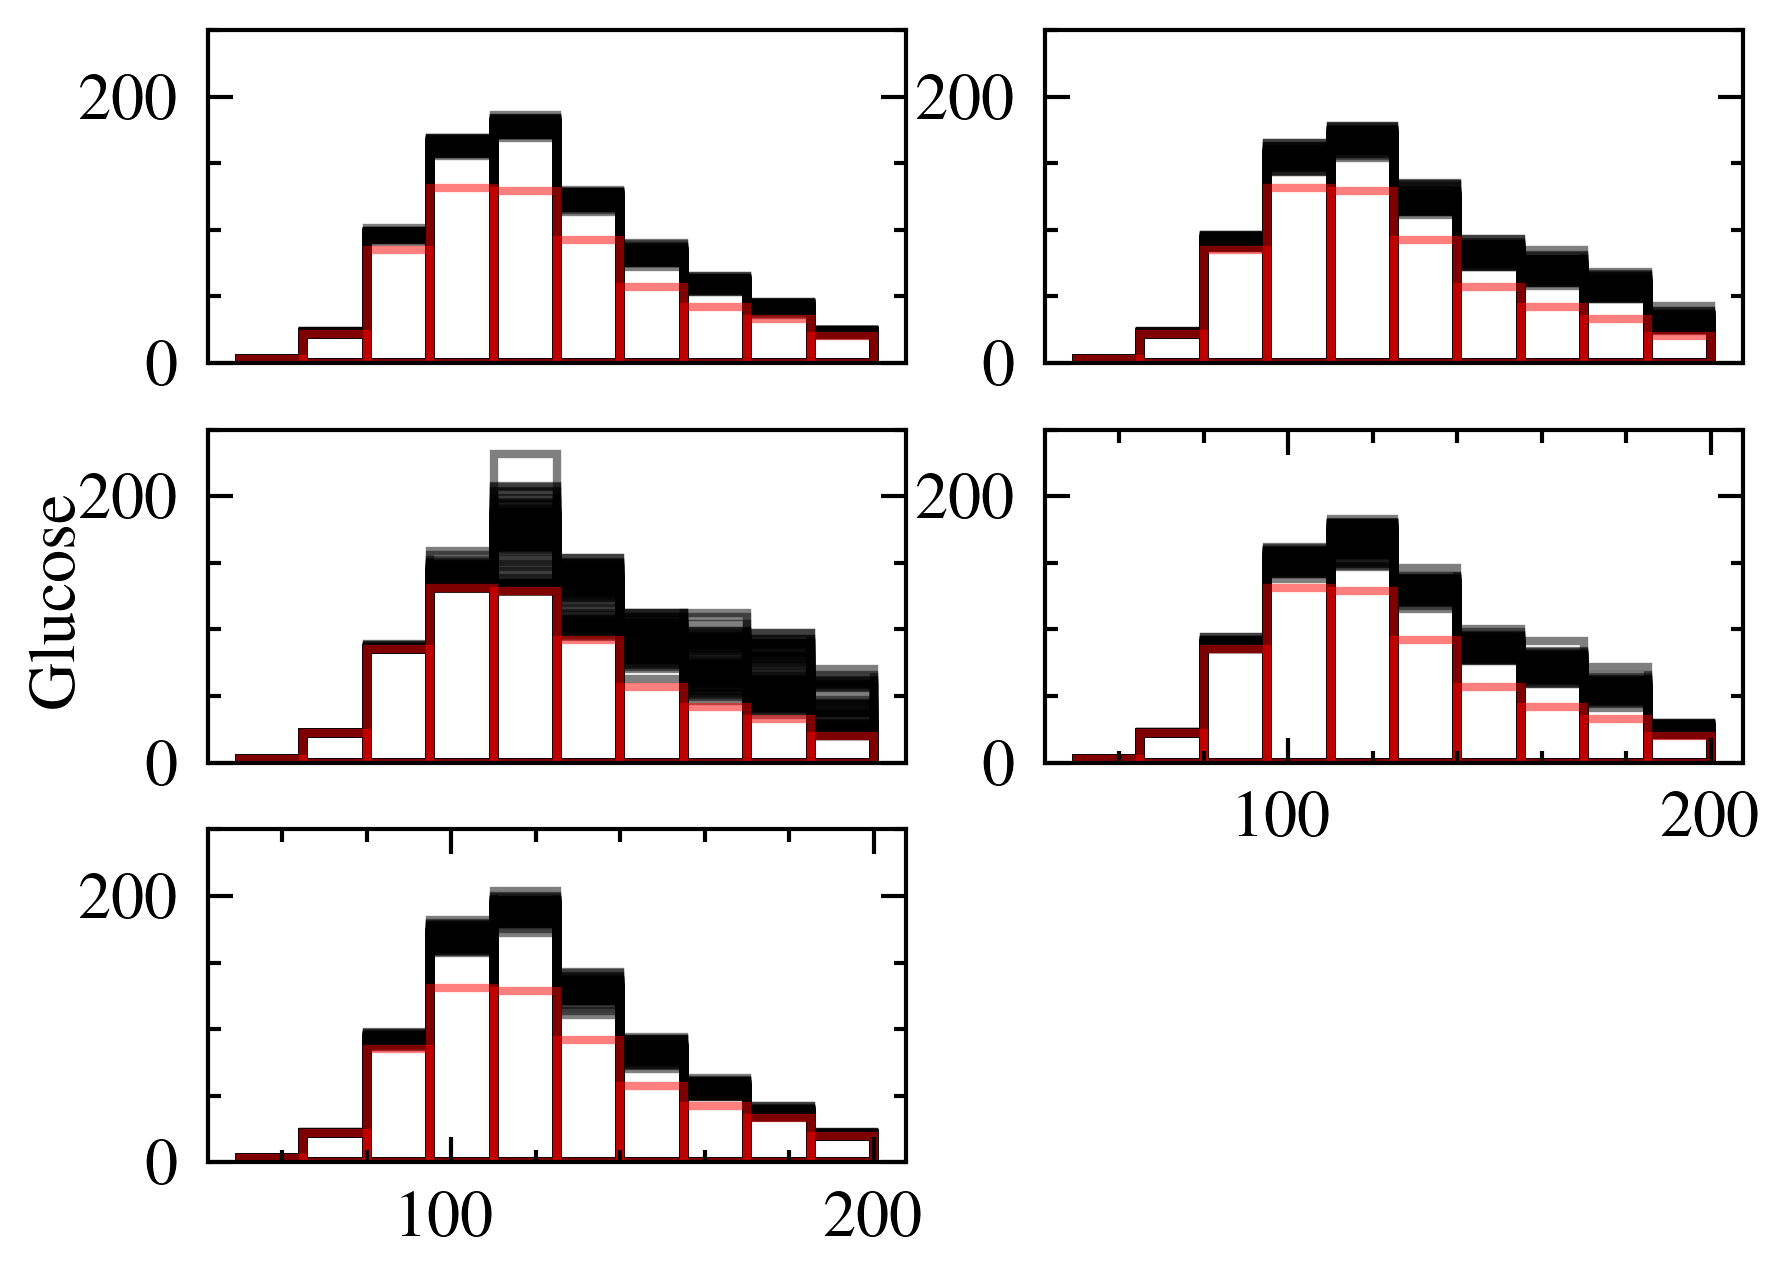

In [5]:

fig, ax = plt.subplots(nrows=3, ncols=2)

# Set IEEE style 
plt.style.use(['science','ieee'])

fig.text(0.035, 0.5, 'Glucose', va='center', rotation='vertical')
for i in range(iterations):
    ax[0,0].hist(adasyn[i]['Glucose'], range = (50,200), alpha=0.5, ec='k', label="ADASYN 100 Iterations", fill=False)
    ax[0,1].hist(smote[i]['Glucose'], range = (50,200), alpha=0.5, ec='k', label="SMOTE 100 Iterations", fill=False)
    ax[1,0].hist(ksmote[i]['Glucose'], range = (50,200), alpha=0.5, ec='k', label="K-SMOTE 100 Iterations", fill=False)
    ax[1,1].hist(svmsmote[i]['Glucose'], range = (50,200), alpha=0.5, ec='k', label="SVM-SMOTE 100 Iterations", fill=False)
    ax[2,0].hist(bord[i]['Glucose'], range = (50,200), alpha=0.5, ec='k', label="Borderline-SMOTE 100 Iterations", fill=False)

ax[0,0].hist(train_data['Glucose'], range = (50,200), alpha=0.5, ec='r', label="Real dataset", fill=False, linewidth = 1)
#ax[0,0].set_xlabel("Data", size=14)
ax[0,0].axes.get_xaxis().set_ticks([])
#ax[0,0].set_title("ADASYN")
ax[0,0].set_ylim([0, 250])

ax[0,1].hist(train_data['Glucose'], range = (50,200), alpha=0.5, ec='r', label="Real dataset", fill=False, linewidth = 1)
#ax[0,1].set_xlabel("Data", size=14)
#ax[0,1].set_title("SMOTE")
ax[0,1].axes.get_xaxis().set_ticks([])
ax[0,1].set_ylim([0, 250])

ax[1,0].hist(train_data['Glucose'], range = (50,200), alpha=0.5, ec='r', label="Real dataset", fill=False, linewidth = 1)
#ax[1,0].set_xlabel("Data", size=14)
#ax[1,0].set_title("K-SMOTE")
ax[1,0].axes.get_xaxis().set_ticks([])
ax[1,0].set_ylim([0, 250])

ax[1,1].hist(train_data['Glucose'], range = (50,200), alpha=0.5, ec='r', label="Real dataset", fill=False, linewidth = 1)
#ax[1,1].set_xlabel("Data", size=14)
#ax[1,1].set_title("SVM-SMOTE")
ax[1,1].set_ylim([0, 250])

ax[2,0].hist(train_data['Glucose'], range = (50,200), alpha=0.5, ec='r', label="Real dataset", fill=False, linewidth = 1)
#ax[2,0].set_xlabel("Data", size=14)
#ax[2,0].set_title("Borderline-SMOTE")
ax[2,0].set_ylim([0, 250])

# Remove box
ax[2,1].set_visible(False)

plt.savefig('histograms_balancing.jpg', dpi = 600)